In [105]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scipy.sparse
import pickle
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer

In [106]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline



In [204]:
df = pd.read_csv("semi_svc78%_prediction.csv", sep=',')

In [205]:
df.head(2)

,id,summary,title,article_date,is_exclusive,total_comments,pageviews,facebook_likes,linkedin_shares,tags,sub_content,content,content_score,summary_score,sum_score,label,semi_label
0,741663,the luxury group's controlling family sold sha...,Ferragamo Shares Tumble After Family Trims Stake,2018-06-20 10:03:44,False,0,985,35,0,salvatoreferragamo,"florence, italy -- shares in salvatoreferraga...","florence, italy -- shares in salvatoreferraga...",-0.052900,0.000000,-0.037030,-1.0,-1.0
1,740019,"with its biggest ever french store, set to ope...",How H&M Is Rethinking Its Flagships,2018-06-19 05:25:29,True,0,11153,112,0,hm,"paris, france -- in the speedy world of fast ...","paris, france -- in the speedy world of fast ...",0.139067,0.084091,0.122574,1.0,1.0


In [206]:
df_tfidf = df['sub_content']
#try to visualise frequency
#https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-3-zipfs-law-data-visualisation-fc9eadda71e7

In [183]:
df1 = df.copy()

In [184]:
for i in range(len(df1)):
    tempdate = df1.loc[i,'article_date']
    tempdate = tempdate[:4]
    df1.loc[i,'article_date'] = tempdate

In [185]:
df1 = df1.drop(['sub_content','content', 'summary','title','id'], axis=1)

In [186]:
df1.head(2)

,article_date,is_exclusive,total_comments,pageviews,facebook_likes,linkedin_shares,tags,content_score,summary_score,sum_score,label,semi_label
0,2018,False,0,985,35,0,salvatoreferragamo,-0.052900,0.000000,-0.037030,-1.0,-1.0
1,2018,True,0,11153,112,0,hm,0.139067,0.084091,0.122574,1.0,1.0


In [187]:
df1['article_date'].value_counts()

2016    1247
2015    1206
2014     870
2013     845
2017     791
2018     532
2012     380
2011     289
2010     195
2009     159
2008      37
2007      10
Name: article_date, dtype: int64

# feature engineering

In [188]:
stopwords_1 = ['like', 'luxury','said','business','fashion',
               'billion','year','years','company','brand','brands',
              'percent','executive','chief-executive','chief','market']

In [189]:
#tfidf
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
stopwords.words('english')[0:10]
def textclean(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    outstr = ''
    for word in nopunc.split():  
        if word not in stopwords_1:    
                outstr += word  
                outstr += " " 
                
    return outstr  
    #clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords_1]
    #return clean_mess
    #return nopunc

In [13]:
#df_tfidf = [textclean(i) for i in df_tfidf] #tokenize

In [215]:
df_tf = [textclean(i) for i in df_tfidf] #non-tokenize
df_tf = pd.DataFrame(df_tf,columns=['text'])

In [216]:
tfidf = TfidfVectorizer(analyzer = "word", max_features = 20, 
                        stop_words="english", ngram_range=(1,3))#compare different ngram_ranges' effect on accuracy
features = tfidf.fit_transform(df_tf['text']).toarray()

In [217]:
feature_name = tfidf.get_feature_names()

In [218]:
features.shape

(6561, 20)

In [192]:
# 文档词条矩阵
dtm = features
columns = tfidf.get_feature_names()
# 将矩阵转换为数据框--即X变量
x_tfidf = pd.DataFrame(dtm, columns=columns)

In [120]:
# Select top features for each test sample
tfidf_tags = []
top_n = -20
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(features)
for i, e in enumerate(tfidf_sorting):
    tmp_tags = []
    indexes = e[top_n:]
    for idx in indexes:
        cur_tag = feature_array[idx]
        if features[i][idx] > 0.1 and len(cur_tag)>3 and '_' not in cur_tag:
            tmp_tags.append(cur_tag.replace(' ', '-'))
    tfidf_tags.append(" ".join(tmp_tags))

In [121]:
df = pd.DataFrame({'tags':tfidf_tags})
df.head(5)

,tags
0,sales group
1,including retail group paris stores
2,retail sales stores
3,group paris according retail sales goods lvmh
4,growth goods sales director gucci creative kering


In [193]:
#one hot encoding
def onehot_encoding(data,cols):
    for col in cols:
        df_temp = pd.get_dummies(data[col],prefix=col, drop_first=True)
        data = data.join(df_temp)
        
    return data

In [194]:
df1.columns

Index(['article_date', 'is_exclusive', 'total_comments', 'pageviews',
       'facebook_likes', 'linkedin_shares', 'tags', 'content_score',
       'summary_score', 'sum_score', 'label', 'semi_label'],
      dtype='object')

In [195]:
#columns=['article_date', 'is_exclusive', 'tags', 'label']
columns=['is_exclusive', 'label']

In [196]:
x_train1 = onehot_encoding(df1,columns)
x_train1 = x_train1.drop([ 'is_exclusive', 'label','article_date','tags'], axis=1)

In [197]:
x_train1.dtypes

total_comments         int64
pageviews              int64
facebook_likes         int64
linkedin_shares        int64
content_score        float64
summary_score        float64
sum_score            float64
semi_label           float64
is_exclusive_True      uint8
label_0.0              uint8
label_1.0              uint8
dtype: object

In [198]:
#concat tfidf features and others
x_joint = pd.concat([x_train1,x_tfidf], axis=1)
x_joint.head()

,total_comments,pageviews,facebook_likes,linkedin_shares,content_score,summary_score,sum_score,semi_label,is_exclusive_True,label_0.0,...,including,kering,lvmh,million,new,nike,paris,retail,sales,stores
0,0,985,35,0,-0.052900,0.000000,-0.037030,-1.0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.472033,0.000000
1,0,11153,112,0,0.139067,0.084091,0.122574,1.0,1,0,...,0.128198,0.000000,0.000000,0.000000,0.307287,0.0,0.252906,0.136640,0.095703,0.344974
2,0,5217,307,0,0.122035,0.045455,0.099061,1.0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.458585,0.0,0.000000,0.285484,0.299931,0.786282
3,0,1907,9,0,0.071508,0.208333,0.112556,1.0,0,0,...,0.000000,0.000000,0.684184,0.000000,0.000000,0.0,0.227841,0.246196,0.344873,0.000000
4,1,26809,1449,0,0.091333,-0.054545,0.047569,1.0,0,0,...,0.095020,0.524504,0.000000,0.089956,0.195223,0.0,0.000000,0.000000,0.283740,0.092979


In [199]:
y = df1['semi_label']
X = x_joint.drop(['semi_label'], axis=1)
#X = x_joint.drop(['semi_label','tags'], axis=1)

In [65]:
#y = df1['semi_label']
#X = x_train1.drop(['semi_label'], axis=1)

In [200]:
x_train, x_val, y_train, y_val = train_test_split(
X, y, test_size=0.24, random_state=42)

In [201]:
len(x_val)

1575

In [132]:
from sklearn.metrics import confusion_matrix 
def confusion_m(y_val, dval_predictions):
    cm = confusion_matrix(y_val, dval_predictions)
    import itertools
    classes = [-1,1]
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in  itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [135]:
# calculate the fpr and tpr for all thresholds of the classification
def roc (y_val, dval_predprob):
    fpr, tpr, threshold = metrics.roc_curve(y_val, dval_predprob)
    roc_auc = metrics.auc(fpr, tpr)

# method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# model

In [133]:
#Set parameter
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=118,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 slient=True)

In [ ]:
def xgbmodel(x_train,y_train,x_val,y_val):
    xgb_param = xgb1.get_xgb_params()
    xgtrain = xgb.DMatrix(x_train, label=y_train)
#cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,
            #metrics='auc',early_stopping_rounds=12,)
#xgb1.set_params(n_estimators=cvresult.shape[0])
#print('running cross validation, disable standard deviation display')
#print(cvresult.shape[0])
        
#Fit the algorithm on the data
    xgb1.fit(x_train, y_train.values.ravel(),eval_metric='auc')
        
#Predict validation set:
    dval_predictions = xgb1.predict(x_val)
    dval_predprob = xgb1.predict_proba(x_val)[:,1]
    
#Save model
#joblib.dump(xgb1, 'xgb1.model')
#Print model report:
    print ("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_val, dval_predictions))
    print ("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val, dval_predprob))
    from sklearn.metrics import classification_report
    print(classification_report(y_val,dval_predictions))  
    roc(y_val, dval_predprob)
    confusion_m(y_val, dval_predictions)


Model Report
Accuracy : 0.7679
AUC Score (Validation): 0.808816
             precision    recall  f1-score   support

       -1.0       0.73      0.56      0.63       399
        1.0       0.78      0.88      0.83       717

avg / total       0.76      0.77      0.76      1116



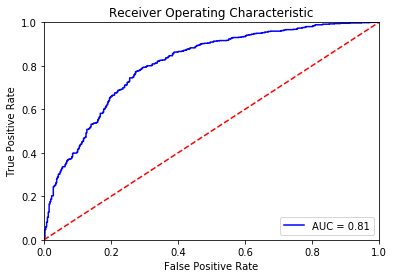

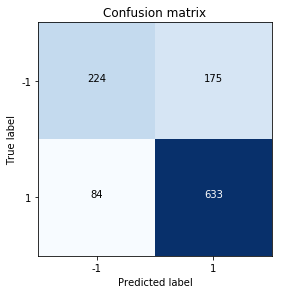

In [154]:
#Model
xgb_param = xgb1.get_xgb_params()
xgtrain = xgb.DMatrix(x_train, label=y_train)
#cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,
            #metrics='auc',early_stopping_rounds=12,)
#xgb1.set_params(n_estimators=cvresult.shape[0])
#print('running cross validation, disable standard deviation display')
#print(cvresult.shape[0])
        
#Fit the algorithm on the data
xgb1.fit(x_train, y_train.values.ravel(),eval_metric='auc')
        
#Predict validation set:
dval_predictions = xgb1.predict(x_val)
dval_predprob = xgb1.predict_proba(x_val)[:,1]
    
#Save model
#joblib.dump(xgb1, 'xgb1.model')
#Print model report:
print ("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_val, dval_predictions))
print ("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val, dval_predprob))
from sklearn.metrics import classification_report
print(classification_report(y_val,dval_predictions))  
roc(y_val, dval_predprob)
confusion_m(y_val, dval_predictions)

In [33]:
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_val, dval_predictions))

[[227 172]
 [ 85 632]]


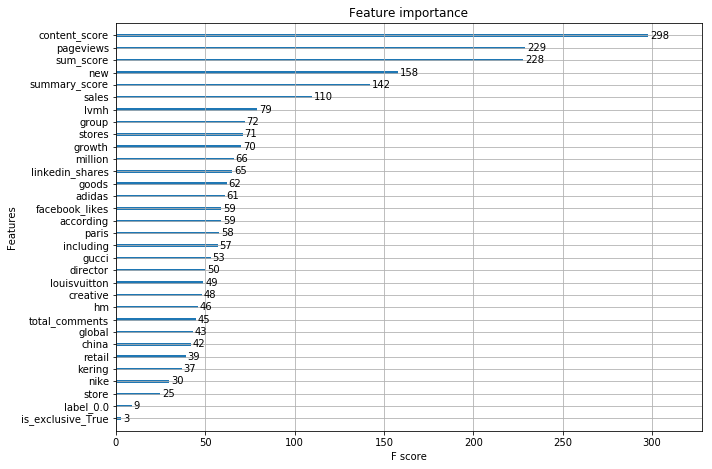

In [304]:
#Plot importance
ax = plot_importance(xgb1)
fig = ax.figure
fig.set_size_inches(10.5, 7.5)
pyplot.show()

In [99]:
#tf-idf
def xgbmodel(x_train,y_train,x_val,y_val):
    xgb_param = xgb1.get_xgb_params()
    xgtrain = xgb.DMatrix(x_train, label=y_train)
#cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,
            #metrics='auc',early_stopping_rounds=12,)
#xgb1.set_params(n_estimators=cvresult.shape[0])
#print('running cross validation, disable standard deviation display')
#print(cvresult.shape[0])
        
#Fit the algorithm on the data
    xgb1.fit(x_train, y_train.values.ravel(),eval_metric='auc')
        
#Predict validation set:
    dval_predictions = xgb1.predict(x_val)
    dval_predprob = xgb1.predict_proba(x_val)[:,1]
    
#Save model
#joblib.dump(xgb1, 'xgb1.model')
#Print model report:
    print ("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_val, dval_predictions))
    print ("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val, dval_predprob))
    roc(y_val, dval_predprob)
    confusion_m(y_val, dval_predictions)
    from sklearn.metrics import classification_report
    print(classification_report(y_val,dval_predictions))


Model Report
Accuracy : 0.7697
AUC Score (Validation): 0.799962


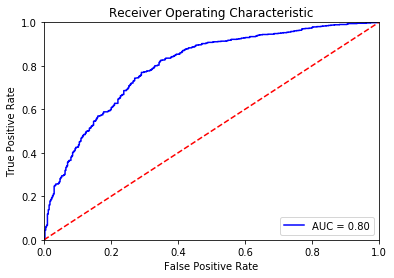

             precision    recall  f1-score   support

       -1.0       0.73      0.57      0.64       399
        1.0       0.79      0.88      0.83       717

avg / total       0.77      0.77      0.76      1116



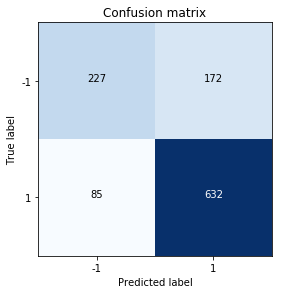

In [100]:
#tf-idf without date
xgbmodel(x_train,y_train,x_val,y_val)

In [269]:
#tf-idf20features without date & tags
xgbmodel(x_train,y_train,x_val,y_val)


Model Report
Accuracy : 0.7697
AUC Score (Validation): 0.799962


In [280]:
#tf-idf25features without date & tags
xgbmodel(x_train,y_train,x_val,y_val)


Model Report
Accuracy : 0.7634
AUC Score (Validation): 0.804258


In [303]:
#tf-idf23features without date & tags
xgbmodel(x_train,y_train,x_val,y_val)


Model Report
Accuracy : 0.7599
AUC Score (Validation): 0.798522



Model Report
Accuracy : 0.7625
AUC Score (Validation): 0.810183


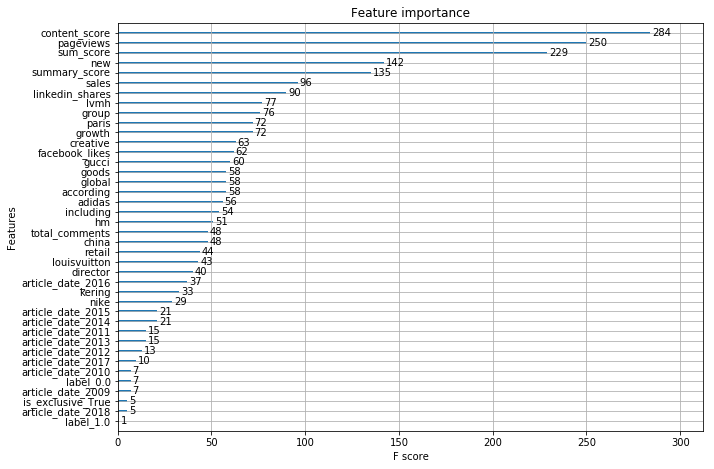

In [376]:
#tf-idf20features without tags
xgbmodel(x_train,y_train,x_val,y_val)
#Plot importance
ax = plot_importance(xgb1)
fig = ax.figure
fig.set_size_inches(10.5, 7.5)
pyplot.show()


Model Report
Accuracy : 0.7848
AUC Score (Validation): 0.811004


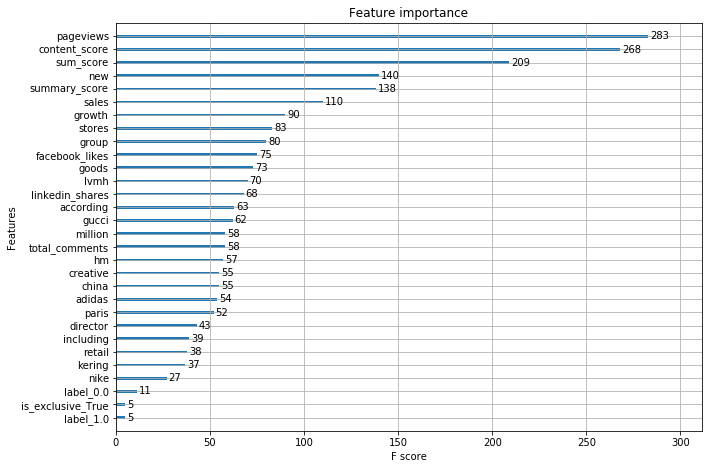

In [496]:
##############best result##########
#tf-idf20features without tags &  date , train_test_split(X, y, test_size=0.24, random_state=42)
xgbmodel(x_train,y_train,x_val,y_val)
#Plot importance
ax = plot_importance(xgb1)
fig = ax.figure
fig.set_size_inches(10.5, 7.5)
pyplot.show()


Model Report
Accuracy : 0.7848
AUC Score (Validation): 0.811004


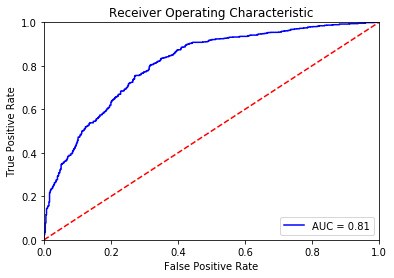

             precision    recall  f1-score   support

       -1.0       0.76      0.57      0.65       551
        1.0       0.79      0.90      0.84      1024

avg / total       0.78      0.78      0.78      1575



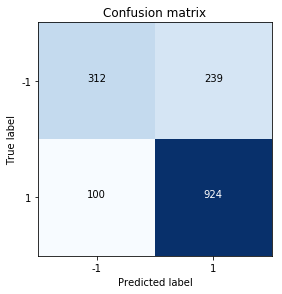

In [202]:
xgbmodel(x_train,y_train,x_val,y_val)

In [485]:
from sklearn.model_selection import cross_val_score
num_folds = 7
scores = cross_val_score(xgb1, x_train, y_train, cv=num_folds, scoring='accuracy')
scores

array([ 0.73858921,  0.72576177,  0.72160665,  0.7184466 ,  0.70596394,
        0.7184466 ,  0.71012483])


Model Report
Accuracy : 0.7473
AUC Score (Validation): 0.786320


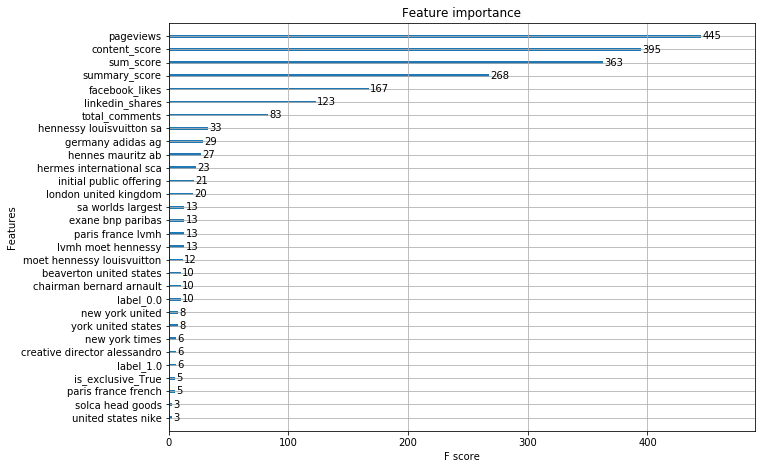

In [509]:
#tf-idf20features without tags &  date , train_test_split(X, y, test_size=0.24, random_state=42) n-gram (3,3)
#n-gram(2,3) accuracy 0.75
xgbmodel(x_train,y_train,x_val,y_val)
#Plot importance
ax = plot_importance(xgb1)
fig = ax.figure
fig.set_size_inches(10.5, 7.5)
pyplot.show()

In [86]:
#svm
from sklearn.svm import SVC
model_svm = SVC(C = 6.8, gamma = 0.001)
model_svc = model_svm.fit(x_train, y_train.values)
pred = model_svc.predict(x_val)
print("Accuracy : %.4g" % metrics.accuracy_score(y_val, pred))
print ("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val, pred))

Accuracy : 0.7222
AUC Score (Validation): 0.648210


In [165]:
#svm default
from sklearn.svm import SVC
def svcmodel(x_train,y_train,x_val,y_val):
    model_svm = SVC(probability=True)
    model_svc = model_svm.fit(x_train, y_train.values)

    dval_predictions = model_svc.predict(x_val)
    dval_predprob = model_svc.predict_proba(x_val)[:,1]
    
#Save model
#joblib.dump(xgb1, 'xgb1.model')
#Print model report:
    print ("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_val, dval_predictions))
    print ("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val, dval_predprob))
    roc(y_val, dval_predprob)
    confusion_m(y_val, dval_predictions)
    from sklearn.metrics import classification_report
    print(classification_report(y_val,dval_predictions))


Model Report
Accuracy : 0.7151
AUC Score (Validation): 0.751560


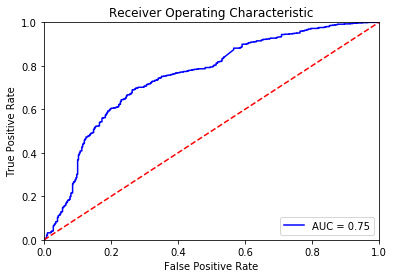

             precision    recall  f1-score   support

       -1.0       0.70      0.36      0.47       399
        1.0       0.72      0.91      0.80       717

avg / total       0.71      0.72      0.69      1116



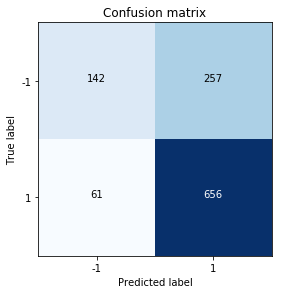

In [164]:
#default parameter
svcmodel(x_train,y_train,x_val,y_val)


Model Report
Accuracy : 0.7204
AUC Score (Validation): 0.767321


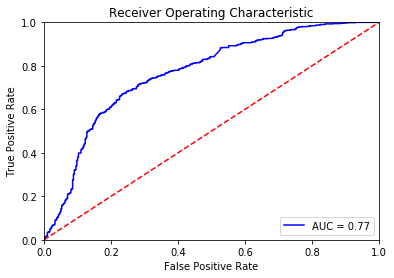

             precision    recall  f1-score   support

       -1.0       0.70      0.39      0.50       399
        1.0       0.73      0.91      0.81       717

avg / total       0.72      0.72      0.70      1116



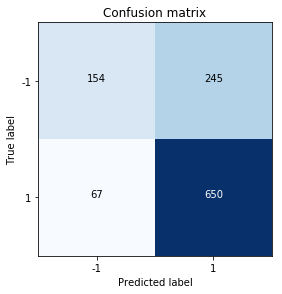

In [166]:
svcmodel(x_train,y_train,x_val,y_val) #c=6.8 gamama= 0.0001 without tf-idf

In [174]:
#svm with tf-idf with grd-search
from sklearn.svm import SVC
def svcmodel(x_train,y_train,x_val,y_val):
    model_svm = SVC(C = 10, gamma = 0.1,probability=True)
    model_svc = model_svm.fit(x_train, y_train.values)

    dval_predictions = model_svc.predict(x_val)
    dval_predprob = model_svc.predict_proba(x_val)[:,1]
    
#Save model
#joblib.dump(xgb1, 'xgb1.model')
#Print model report:
    print ("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_val, dval_predictions))
    print ("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val, dval_predprob))
    roc(y_val, dval_predprob)
    confusion_m(y_val, dval_predictions)
    from sklearn.metrics import classification_report
    print(classification_report(y_val,dval_predictions))


Model Report
Accuracy : 0.767
AUC Score (Validation): 0.816399


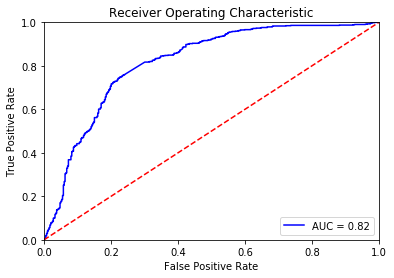

             precision    recall  f1-score   support

       -1.0       0.71      0.60      0.65       399
        1.0       0.79      0.86      0.83       717

avg / total       0.76      0.77      0.76      1116



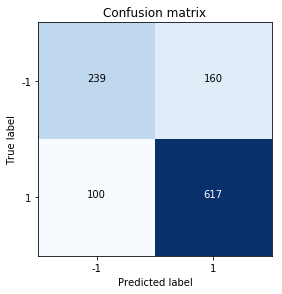

In [175]:
svcmodel(x_train,y_train,x_val,y_val) #with best c and gamma with tags and date with 0.17 split

In [176]:
#Plot importance


ValueError: tree must be Booster, XGBModel or dict instance


Model Report
Accuracy : 0.7695
AUC Score (Validation): 0.812934


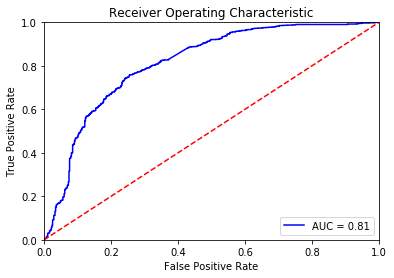

             precision    recall  f1-score   support

       -1.0       0.74      0.53      0.62       551
        1.0       0.78      0.90      0.84      1024

avg / total       0.77      0.77      0.76      1575



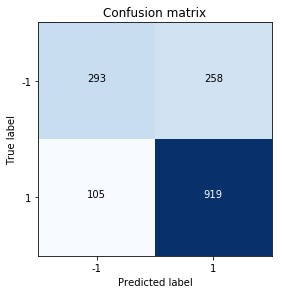

In [203]:
svcmodel(x_train,y_train,x_val,y_val) #c=10 gamama= 0.01 with tf-idf without tags and date with 0.24

In [167]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(), param_grid={"C":[0.1,1,2,2.5,3,4,5,10], "gamma": [0.001,0.005,0.05,0.1,0.15]}, cv=3)
grid.fit(x_train, y_train.values)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10, 'gamma': 0.1} with a score of 0.74


In [231]:
#svm tf-idf
from sklearn.svm import SVC
model_svm = SVC(C = 6.8, gamma = 0.001)
model_svc = model_svm.fit(x_train, y_train.values)
pred = model_svc.predict(x_val)
print("Accuracy : %.4g" % metrics.accuracy_score(y_val, pred))
print ("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val, pred))

Accuracy : 0.7213
AUC Score (Validation): 0.647513


In [241]:
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.models import Sequential
import keras
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
import time
start = time.time()

In [242]:
#parameters for LSTM
nb_lstm_outputs = 500  #神经元个数
nb_time_steps = 1  #时间序列长度
nb_input_vector = 782 #输入序列

In [243]:
#lstm

def get_model():
    #params
    dr_r = 0.5
    
    #Inputs
    Comments= Input(shape=(1,782), name="comments")
    Activ = Activation('tanh')(Comments)
    
    #rnn layer
    rnn_layer1 = LSTM(1024) (Activ)
    
    rnn_layer1 = Dropout(dr_r) (Dense(256) (rnn_layer1))
    rnn_layer1 = Dropout(dr_r) (Dense(128) (rnn_layer1))
    rnn_layer1 = Dropout(dr_r) (Dense(64) (rnn_layer1))
    #output
    output = Dense(1, activation="softsign") (rnn_layer1)
    
    #model
    model = Model(Comments, output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return model

    
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comments (InputLayer)        (None, 1, 782)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 1, 782)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              7401472   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [ ]:
scaletrainVecs_lstm = np.reshape(scaletrainVecs, (scaletrainVecs.shape[0], 1, scaletrainVecs.shape[1]))
scaletestVecs_lstm = np.reshape(scaletestVecs, (scaletestVecs.shape[0], 1, scaletestVecs.shape[1]))

In [245]:
BATCH_SIZE = 150
epochs = 35
model.fit(x_train, y_train.values, epochs=epochs, batch_size=BATCH_SIZE
          ,verbose=1)
#http://www.sohu.com/a/162003640_465944 计算val_loss模型泛化能力
scores = model.evaluate(x_val, y_val.values, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

ValueError: Error when checking input: expected comments to have 3 dimensions, but got array with shape (5445, 781)

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
 
# Add noisy features
n_samples, n_features = x_train.shape
random_state = np.random.RandomState(0)
x_train = np.c_[x_train, random_state.randn(n_samples, 200 * n_features)]

# Run classifier with cross-validation and plot ROC curves
#使用6折交叉验证，并且画ROC曲线
cv = StratifiedKFold(y, n_folds=6)
classifier = svm.SVC(kernel='rbf', probability=True,
                     random_state=random_state)#注意这里，probability=True,需要，不然预测的时候会出现异常。另外rbf核效果更好些。
 
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
 
for i, (train, test) in enumerate(cv):
	#通过训练数据，使用svm线性核建立模型，并对测试集进行测试，求出预测得分
    probas_ = classifier.fit(x_train, y_train).predict_proba(x_val)
#    print set(y[train])                     #set([0,1]) 即label有两个类别
#    print len(X[train]),len(X[test])        #训练集有84个，测试集有16个
#    print "++",probas_                      #predict_proba()函数输出的是测试集在lael各类别上的置信度，
#    #在哪个类别上的置信度高，则分为哪类
    # Compute ROC curve and area the curve
    #通过roc_curve()函数，求出fpr和tpr，以及阈值
    fpr, tpr, thresholds = roc_curve(y_val, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)			#对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数
    mean_tpr[0] = 0.0 								#初始处为0
    roc_auc = auc(fpr, tpr)
    #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
#画对角线
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
 
mean_tpr /= len(cv) 					#在mean_fpr100个点，每个点处插值插值多次取平均
mean_tpr[-1] = 1.0 						#坐标最后一个点为（1,1）
mean_auc = auc(mean_fpr, mean_tpr)		#计算平均AUC值
#画平均ROC曲线
#print mean_fpr,len(mean_fpr)
#print mean_tpr
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
 
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()